# Welcome to spectral fitting with COSIpy classic

In this notebook, we'll perform a spectral fit on the Crab nebula and Centaurus A using simulated balloon flight data.

The point sources that have been simulated are:
- Crab nebula (184.56, −5.78) - The Crab nebula is considered both a pulsar wind nebula (PWN) and supernova remnant. The PWN surrounds the Crab Pulsar, a rapidly rotating and magnetized neutron star in the Milky Way constellation Taurus. The supernova remnant was produced by SN 1054. The Crab entered COSI-balloon's field of view for only ~12 of the 46 days of the 2016 flight (Sleator 2019); the balloon remained largely in Earth's Southern Hemisphere and the Crab is more easily viewed from the Northern Hemisphere. Nevertheless, as the brightest persistent γ-ray source in the sky, the Crab is detectable in the balloon data and is imaged in this notebook with 10x its true flux of 0.049 ph cm$^{-2}$ s$^{-1}$ (100 keV-50 MeV).
- Centaurus A (309.52, 19.42) - Centaurus A is a galaxy in the constellation of Centaurus. Also called NGC 5128, Centaurus A has a supermassive black hole which emits X-rays, radio waves, and gamma-rays. This notebook attempts to recover the spectrum of Centaurus A with 10x its true flux of 0.0036 ph cm$^{-2}$ s$^{-1}$ (100 keV-50 MeV) during the 2016 balloon flight.

There are other simulated sources in the data set - Cygnus X-1, Vela, the 511 keV emission from positron annihilation and the Al-26 1.8 MeV decay line - but these are not explored in this notebook.

## Import packages.

We're using the COSIpy classic functions in COSIpy_dc1.py, response_dc1.py, and fit_dc1.py.

In [1]:
from COSIpy_dc1 import *
import response_dc1 as response
from fit_dc1 import *

Welcome to JupyROOT 6.24/06


/Users/eneights/software/COSItools/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


## Define file names.

DC1_combined_10x.tra.gz is a simulation of 4 point sources (Crab, Cen A, Cyg X-1, Vela), the 511 keV & Al26 lines, and Ling background.

CenA_BG_10x.tra.gz is a simulation of only Cen A and Ling background.

The background response was created using a simulation of the Ling background, and it is constant in time.

In [2]:
data_dir = '../data_products' # directory containing data & response files
filename_combined = 'DC1_combined_10x.tra.gz' # combined simulation
filename_cenA = 'CenA_BG_10x.tra.gz' # Cen A simulation
response_filename = data_dir + '/Continuum_Response.npz' # detector response
background_filename = data_dir + '/Scaled_Ling_BG_1x.npz' # background response
background_mode = 'from file'

## Define inputs.

You can perform the spectral fit on another point source, such as Cyg X-1 or Vela, by changing the latitude and longitude

In [3]:
l_crab,b_crab = 184.55746, -5.78436 # Galactic longitude & latitude of Crab
l_cenA,b_cenA = 309.51584, 19.41709 # Galactic longitude & latitude of Cen A

ul = 3 # SNR limit for upper limits on spectral fit

## Read in simulation and define analysis object.

Read in the data set and create the main cosipy-classic “analysis_combined" object, which provides various functionalities to study the specified file. This cell usually takes a few minutes to run.

In [4]:
analysis_combined = COSIpy(data_dir,filename_combined) # create analysis object
analysis_combined.read_COSI_DataSet() # read in data

## Define the bins for the Compton Data Space.

**Time bins:** The COSI-balloon instrument freely floated on the balloon platform. This means that, unlike a space or ground-based telescope with well-defined pointings and slewing schedule, its orientation was largely dependent on the unconstrained path of the balloon. It was a zenith-pointing instrument, meaning that its vertical orientation pointed straight above the hanging instrument, towards the balloon above it.

The exception to this freedom is that during the day time, COSI's azimuthal orientation was fixed such that its solar panels remained oriented facing the Sun. At nighttime, though, the instrument freely rotated about its azimuth.

This is all to say that COSI's orientation (e.g. roll/pitch/yaw) changed rapidly during flight. As such, we might prefer to bin the data into very small (~seconds) time bins to preserve an accurate orientation of the instrument tied to the data. However, this would require massive computational resources. Also, time bins which are too small may contain too few photons for meaningful analysis.

Through extensive testing, **7200 second** (2 hour) time bins were found to strike a practical balance between a sufficiently precise treatment of instrument orientation and computational means.

**Energy bins:** We need to define the energy bins exactly as they are defined in the response. For point source spectral fitting, we use a continuum response simulation which spans several energy bins across COSI's 0.2-5 MeV bandpass: (150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000) keV.

**Sky pixel size:** As with the energy binning, the pixel size here must match that of the response. The responses that have been simulated for COSI-balloon assume 6°×6° resolution. The Compton Data Space (CDS) has 3 angular dimensions: the Compton scattering angle (ϕ), and the direction of the scattered photon in a Compton interaction (χ and ψ).

In [5]:
Delta_T = 7200 # time bin size in seconds
energy_bin_edges = np.array([150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000]) # energy bin edges in keV

pixel_size = 6. # pixel size in degrees

## Bin the data.

The data are binned into time, energy, ϕ and FISBEL. FISBEL is a unique index which specifies the χ and ψ dimensions of the CDS.

In [6]:
analysis_combined.dataset.time_binning_tags(time_bin_size=Delta_T) # time binning
analysis_combined.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=pixel_size) # energy and pixel binning
analysis_combined.dataset.get_binned_data() # bin data

## Examine the shape of the binned data.

The binned data are contained in "analysis_combined.dataset.binned_data". This is a 4-dimensional object representing the 5 dimensions of the Compton data space (time, energy, ϕ, FISBEL).

Per the binning definitions above, there are 560 time bins, 10 energy bins (as governed by those in the response), 30 ϕ bins (30 bins of 6° spanning the full 0−180° range of possible Compton scattering angles), and 1145 FISBEL bins.

How do we end up with 1145 FISBEL bins? Consider a sphere which is $4\pi(\frac{180^{\circ}}{\pi})^{2}=41252.96$ deg$^2$. Given our 6 deg$^2$ binning, we have $\frac{41252.96}{6} \approx 1145$ bins.

This prints the shape of the binned data, the total time in the dataset, the number of time bins that have counts in them, and the number of counts in each time bin. Due to this energy range being so background dominated, the number of counts in each bin is very similar.

In [7]:
print('Number of bins in each dimension (time, energy, ϕ, FISBEL):')
print(analysis_combined.dataset.binned_data.shape)
print()
print('Total time in dataset (s):')
print(analysis_combined.dataset.times.total_time)
print()
print('Number of populated time bins:')
print(analysis_combined.dataset.times.n_ph)
print()
print('Number of counts in each time bin: ')
print(analysis_combined.dataset.times.n_ph_t)

Number of bins in each dimension (time, energy, ϕ, FISBEL):
(560, 10, 30, 1145)

Total time in dataset (s):
4031996.412727833

Number of populated time bins:
560

Number of counts in each time bin: 
[11092 11246 11156 11160 11198 11177 11343 11210 11328 11180 11203 11093
 11089 11430 11311 11292 11301 11287 11459 11589 11325 11421 11031 11206
 11271 11433 11628 11387 11095 11331 11382 11285 11304 11355 11358 11090
 10996 11278 11359 11225 11293 11059 11258 11387 11159 11376 11380 11184
 11054 11135 11189 11225 11189 11219 11350 11366 11334 11281 11130 11066
 11142 11106 11082 11196 11325 11409 11162 11202 11256 10971 11040 11327
 11250 11134 11341 11117 11212 11400 11426 11390 11309 11089 11077 11187
 11161 11221 11345 11339 11310 11301 11331 11219 11080 11143 11200 11111
 11141 11345 11247 11378 11357 11334 11493 11386 11296 10958 11335 11237
 11215 11323 11333 11459 11407 11235 11140 11119 10996 11278 11366 11302
 11166 11221 11296 11513 11398 11182 11308 11262 11223 11471 11368 1129

## Plot the raw spectrum & light curve for the combined simulation.

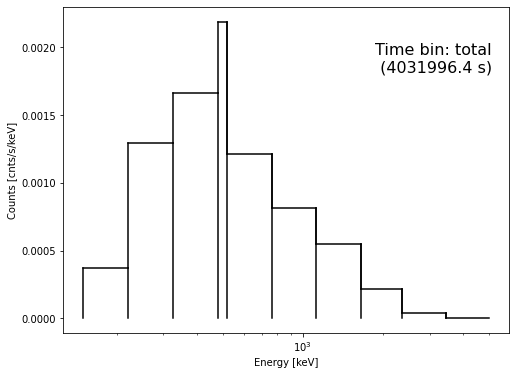

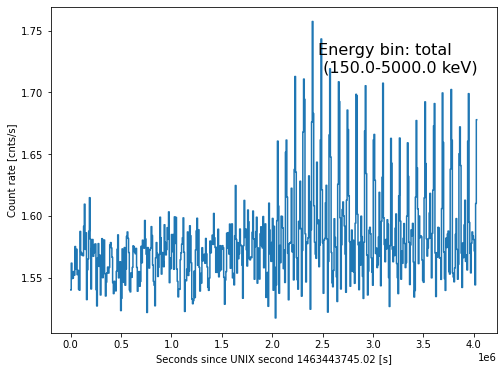

In [8]:
analysis_combined.dataset.plot_raw_spectrum()
plt.xscale('log')

analysis_combined.dataset.plot_lightcurve()

## Define the pointing object with the COSIpy pointing class.

The pointings refer to the direction perpendicular to the face of the telescope at each point in time. This cell usually takes a few minutes to run.

In [9]:
pointing_combined = Pointing(dataset=analysis_combined.dataset) # definition of pointings (balloon stability + Earth rotation)

## Visualize the paths of the Crab & Cen A through the field-of-view.

This isn't necessary for the spectral fitting, but is illustrative for understanding the pointings and exposure of the point sources.

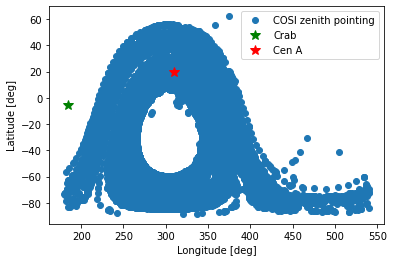

In [10]:
plt.plot(pointing_combined.zpoins[:,0]+360,pointing_combined.zpoins[:,1],'o', label="COSI zenith pointing")
plt.plot(l_crab,b_crab,'*g',markersize=10, label="Crab")
plt.plot(l_cenA,b_cenA,'*r',markersize=10, label="Cen A")
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.legend()

Below, we see the sources move in and out of the field of view. The black dots show when each source is above the horizon (i.e. within COSI's field of view). 

The Crab is more visible in the latter part of the flight. We notice, too, that the Crab is always somewhat off-axis; it is never directly overhead the instrument at zenith.
 
This is also evident in the above pointing plot: the black dots tracing COSI's zenith pointing don't overlap with the Crab's position, marked by a red star.

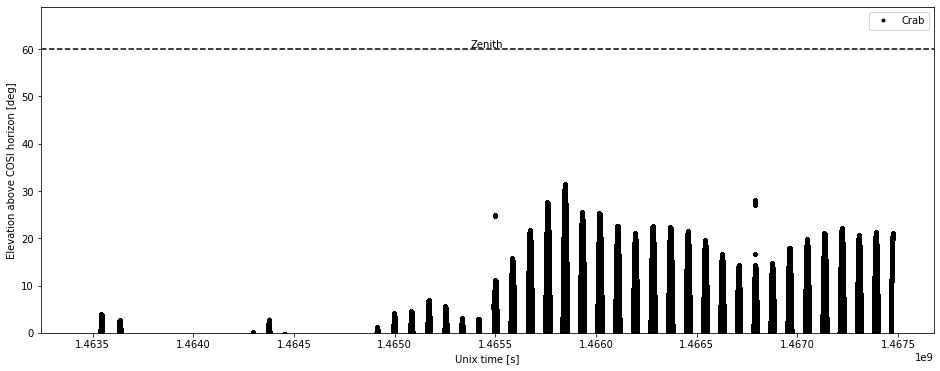

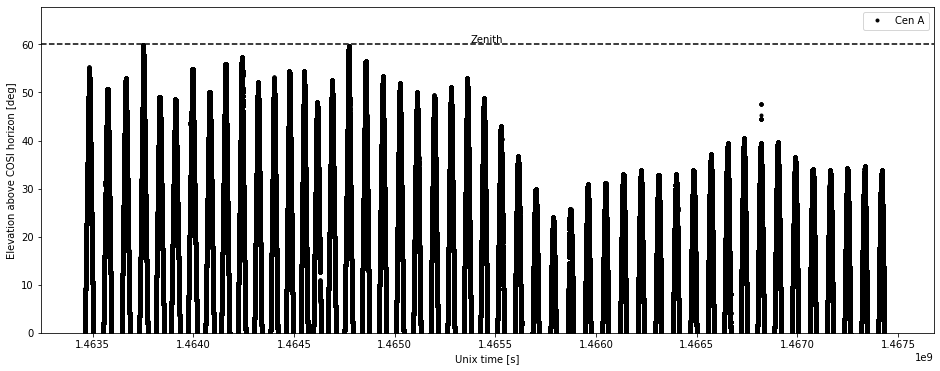

In [11]:
analysis_combined.plot_elevation([l_crab],[b_crab],['Crab'])

analysis_combined.plot_elevation([l_cenA],[b_cenA],['Cen A'])

## Define the background model.

We model the background using extensive simulations of Earth's atmospheric $\gamma$-ray background. The simulations assume the Ling model of atmospheric $\gamma$-ray emission ([Ling 1975](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JA080i022p03241), which is often adopted for this purpose in MeV $\gamma$-ray astrophysics experiments.

The simulations use an accurate mass model of the COSI-balloon instrument during flight and follow the true orientation of the instrument as it traveled along its flight path. Notably, this background model excludes the significant background from instrumental activation. Instrumental activation refers to the excitation of instrument materials by bombarding high-energy particles, e.g. cosmic rays. The instrument materials subsequently de-excite via the emission of $\gamma$-rays which fall in COSI's energy bandpass. Often, the de-excitation lines exactly overlap with astrophysical lines of interest, including 511 keV and 1809 keV.

A complete treatment of the background, therefore, would include both atmospheric and instrumental activation simulations. For simplicity, however, in this spectral analysis tutorial we model only atmospheric background. Future data challenges will include instrumental activation.

In [12]:
background_combined = BG(dataset=analysis_combined.dataset,mode=background_mode,filename=background_filename) # read in background

Using background mode: from file


## Read in the response.

This usually takes a few minutes.

In [13]:
rsp = response.SkyResponse(filename=response_filename,pixel_size=pixel_size) # read in detector response

Reading complete continuum response.
Done.

Creating general RMF matrices.


Loop over phi bins:: 100%|██████████████████████| 30/30 [00:35<00:00,  1.17s/it]


Done.

Creating general IRF.
Done.

Deleting full matrix.
Done.


## Explore the shape of the data space.

The shape of the response spans (Galactic latitude $b$, Galactic longitude $\ell$, Compton scattering angle $\phi$, FISBEL, energy). The size of each dimension depends on the chosen pixel size. Here, we've chosen $6^{\circ}$ pixels. 

Galactic latitude $b \in [-90^{\circ}, 90^{\circ}] \rightarrow$ 30 bins.\
Galactic longitude $\ell \in [-180^{\circ}, 180^{\circ}] \rightarrow$ 60 bins.\
Compton scattering angle $\phi \in [0^{\circ}, 180^{\circ}] \rightarrow$ 30 bins ("analysis1.dataset.phis.n_phi_bins").\
See above for explanation of 1145 FISBEL bins ("rsp.rsp.n_fisbel_bins").\
The continuum response has 10 energy bins.

The shape of the data and background objects span (time, energy, Compton scattering angle, FISBEL), as explained above.

Given the time bin size "Delta_T" which we defined at the beginning of the notebook, there are 560 time bins.

In [14]:
print('Shape of response matrix (b, l, ϕ, FISBEL, energy):')
print(rsp.rsp.response_grid_normed_efinal.shape)
print()
print('Shape of binned data (time, energy, ϕ, FISBEL):')
print(analysis_combined.dataset.binned_data.shape)
print()
print('Shape of background model (time, energy, ϕ, FISBEL):')
print(np.shape(background_combined.bg_model))

Shape of response matrix (b, l, ϕ, FISBEL, energy):
(30, 60, 30, 1145, 10)

Shape of binned data (time, energy, ϕ, FISBEL):
(560, 10, 30, 1145)

Shape of background model (time, energy, ϕ, FISBEL):
(560, 10, 30, 1145)


## Calculate the point source response for the Crab.

In [15]:
rsp.calculate_PS_response(analysis_combined.dataset,pointing_combined,l_crab,b_crab,1,background=background_combined,pixel_size=pixel_size,lookup=False)

Loop over pointings:: 100%|███████████| 45853/45853 [00:00<00:00, 110566.98it/s]


## Plot light curves for the data, background & sky models.

This is plotted for the 220-325 keV energy bin. The sky model is normalized to 1.

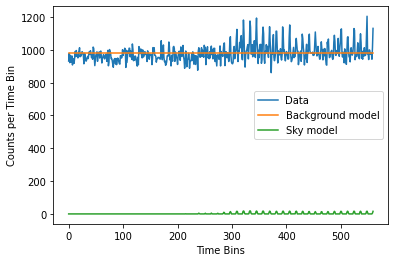

In [16]:
plt.plot(np.sum(analysis_combined.dataset.binned_data[:,1,:,:],axis=(1,2)), label="Data") # binned data light curve
plt.plot(np.sum(background_combined.bg_model_reduced[1],axis=1), label="Background model") # background model
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000, label="Sky model") # sky model
plt.xlabel('Time Bins')
plt.ylabel('Counts per Time Bin')
plt.legend()

## Extract the spectrum for the Crab.

For each energy bin individually, this determines the coefficients for the sky and background models that best match the data. It can take a few hours to run!

In [17]:
result_crab = fit(analysis_combined.dataset,pointing_combined,rsp,background_combined) # create fitting object
result_crab.fit(iters=2000) # perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|████████████████| 10/10 [1:17:18<00:00, 463.89s/it]


## Plot the final count spectrum of the Crab.

Below is the spectrum (in counts/keV) of the Crab nebula!

The fitted value for the 480-520 keV bin is a bit low, which is likely due to the 511 keV line in the simulation.

The extracted spectrum data is saved as a .dat file.

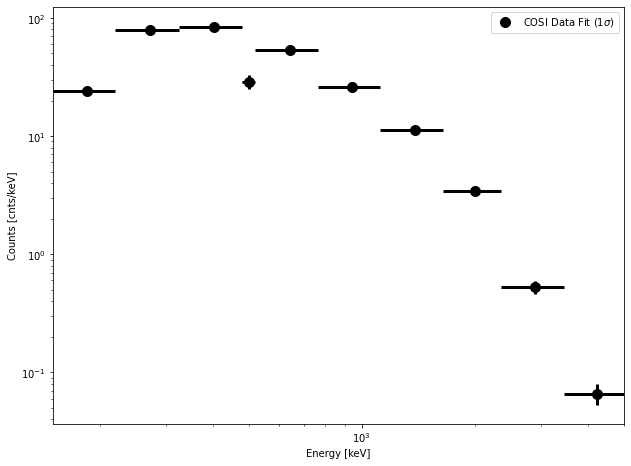

In [18]:
result_crab.plot_extracted_spectrum('crab_spectrum.dat')

## Analysis of Cen A.

Now that we have successfully recovered the Crab spectrum from the full flight simulation, we will look at a slightly weaker source and discover some of the limitations with the current COSIpy classic implementation.

Since we’ve already loaded the COSI-balloon simulated data, response matrix and background model, we only need to redefine the point source sky model using Cen A’s coordinates and repeat the fit.

## Calculate the point source response for Cen A.

In [19]:
rsp.calculate_PS_response(analysis_combined.dataset,pointing_combined,l_cenA,b_cenA,1,background=background_combined,pixel_size=pixel_size,lookup=False)

Loop over pointings:: 100%|████████████| 45853/45853 [00:00<00:00, 78458.57it/s]


## Extract the spectrum for Cen A.

This can take a few hours to run!

In [35]:
result_cenA = fit(analysis_combined.dataset,pointing_combined,rsp,background_combined) # create fitting object
result_cenA.fit(iters=2000) # perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|██████████████████| 10/10 [1:17:03<00:00, 462.39s/it]


## Plot the spectrum of Cen A.

Below is the spectrum (in counts/keV) of the Cen A, with the extracted spectrum data saved as a .dat file.

The first plot includes error bars on each point, and the second shows upper limits where the signal-to-noise ratio (SNR) > 3.

The error bars for Cen A are very large, and almost all energy bins have upper limits. We believe this is due to the Crab's brightness interfering with the fit. To fix this, we need to include the Crab in the background model. Because the elevation of the Crab in COSI's field of view is changing over time, our background model would now be time-dependent. However, our current fitting algorithm only includes one background parameter, so we cannot handle a time-dependent background. Future versions of COSIpy will fix this issue.

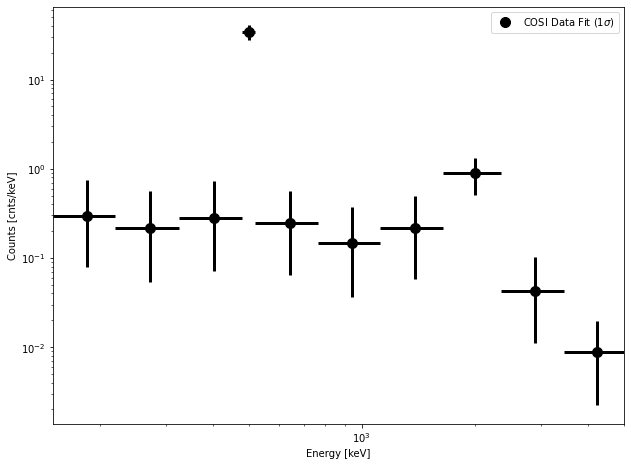

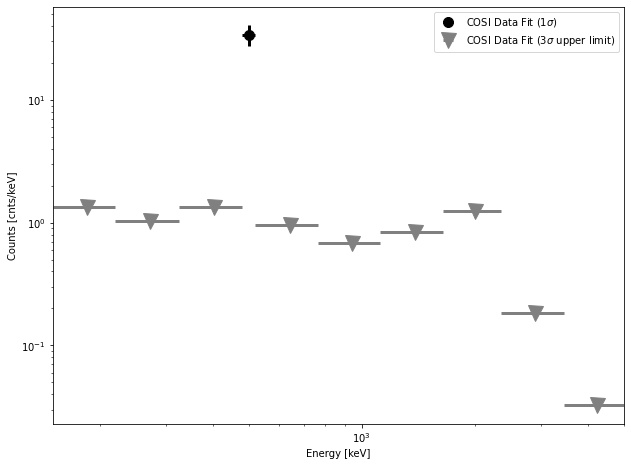

In [36]:
result_cenA.plot_extracted_spectrum('cenA_spectrum1.dat')
result_cenA.plot_extracted_spectrum('cenA_spectrum1.dat',ul=ul)

## Read in Cen A simulation and define analysis object.

To investigate why the fit is failing using the combined simulation, we will redo the Cen A analysis, but we will use a simulation that excludes the Crab and all other sources. The 'CenA_BG_10x.tra.gz' file includes only Cen A and the Ling background, and by repeating the above analysis, we will show that we can recover the Cen A count spectrum when the background model is static. For this analysis, we will only include the required cells. Please refer to the Crab analysis above for the details of each step.

This cell usually takes a few minutes to run.

In [37]:
analysis_cenA = COSIpy(data_dir,filename_cenA) # create analysis object
analysis_cenA.read_COSI_DataSet() # read in data

## Bin the data.

In [38]:
analysis_cenA.dataset.time_binning_tags(time_bin_size=Delta_T) # time binning
analysis_cenA.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=pixel_size) # energy and pixel binning
analysis_cenA.dataset.get_binned_data() # bin data

## Define the pointing object.

This cell usually takes a few minutes to run

In [44]:
pointing_cenA = Pointing(dataset=analysis_cena.dataset)

## Define the background model.

In [46]:
background_cenA = BG(dataset=analysis_cena.dataset,mode=background_mode,filename=background_filename) # read in background

Using background mode: from file


## Calculate the point source response for Cen A.

In [47]:
rsp.calculate_PS_response(analysis_cenA.dataset,pointing_cenA,l_cenA,b_cenA,1,background=background_cenA,pixel_size=pixel_size,lookup=False)

Loop over pointings:: 100%|█████████████| 45844/45844 [00:00<00:00, 114579.65it/s]


## Plot light curves for data, background & sky models.

This is plotted for the 220-325 keV energy bin. The sky model is normalized to 1.

You can see that the data rates appear flatter here compared to the light curve above for the combined simulation. The Crab was mainly in COSI's field of view during the second half of the flight, and since we no longer have those additional counts, there is less variation in this light curve and sky model.

Text(0.5, 0, 'Time Bins')

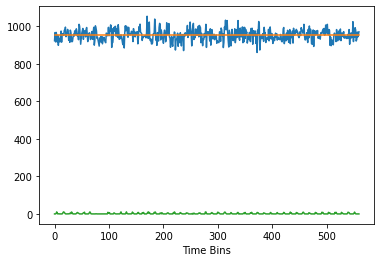

In [48]:
plt.plot(np.sum(analysis_cenA.dataset.binned_data[:,1,:,:],axis=(1,2)), label="Data") # binned data light curve
plt.plot(np.sum(background_cenA.bg_model_reduced[1],axis=1), label="Background model") # background model
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000, label="Sky model") # sky model
plt.xlabel('Time Bins')
plt.ylabel('Counts per Time Bin')
plt.legend()

## Extract the spectrum for Cen A.

This can take a few hours to run!

In [50]:
result_cenA2 = fit(analysis_cenA.dataset,pointing_cenA,rsp,background_cenA) # create fitting object
result_cenA2.fit(iters=2000) # perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|██████████████████| 10/10 [1:19:27<00:00, 476.71s/it]


## Plot the final count spectrum of Cen A.

Below is the spectrum (in counts/keV) of Centaurus A!

When we use a simulation of only Cen A and background, we are able to recover the correct spectrum. This emphasizes the need for more sophisticated background models which include time variability and bright sources, and this will be a focus for the next Data Challenge.

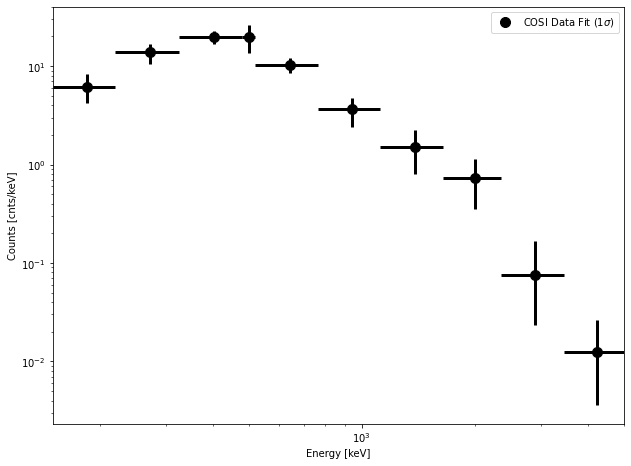

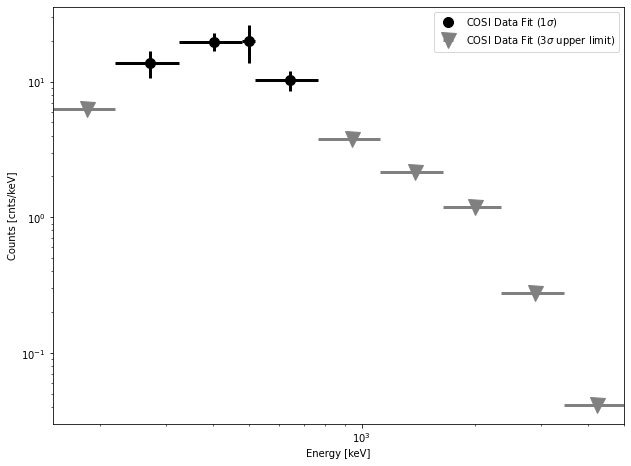

In [52]:
result_cena2.plot_extracted_spectrum()
result_cena2.plot_extracted_spectrum(ul=ul)